In [46]:
from scipy.integrate import solve_ivp
from scipy.signal import lombscargle

import numpy as np
import matplotlib.pyplot as plt

In [47]:
# derivative functions on x and y; include effect of light
# t: time (hrs)
# l (lambda): rate of return from a disturbance (hrs^-1)
# A: amplitude of base oscillation
# tau: period of base oscillation (hrs)
# ifunc: light intensity as a function of t
def cartesian_lights(t, p, l, A, tau, ifunc):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    
    # see equations 4 and 5 in the paper (section 4.1)
    dx = l * x * (A - r) - 2 * np.pi * y / tau - ifunc(t)
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    
    return [dx, dy]

# get the solution of a simulated oscillator affected by the given light intensity function
# returns t, (x, y)
def get_simulation_result(l, tau, ifunc, hours, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)

    p0 = [A, 0]
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)

    return t, result.y

In [48]:
# 12 hrs light (1), 12 hrs dark (0)
def LD_step(t):
    t_day = t % 24

    step = 1 - np.round(t_day / 24)
    return step

In [49]:
def get_simulation_period(l, tau, max_intensity, hours=144):
    intensity = lambda x: LD_step(x) * max_intensity
    
    t, (x, y) = get_simulation_result(l, tau, intensity, hours)
    
    periods = np.arange(1, 10, .01)
    
    powers = lombscargle(t[len(x)//2:], x[len(x)//2:], freqs=1/periods)
    
    peak_freq = periods[powers.argmax()] * 6.25

    return peak_freq

In [50]:
import sys

def ranges(i, j, tau_range, light_range, size_i, size_j):
    l = .5
    
    tau = np.interp(i, [0, size_i], tau_range)

    light = np.interp(j, [0, size_j], light_range)
    
    return np.array([tau, light])

size_x = 40
size_y = 40

im_shape = (size_x, size_y)

tau_range = [20, 28]
light_range = [0, .15]

param_array = np.fromfunction(lambda i, j: ranges(i, j, tau_range, light_range, *im_shape), (size_x + 1, size_y + 1))

def generator(x):
    l = .5
    sys.stdout.write("\r%f, %f" % (x[0], x[1]))
    sys.stdout.flush()
    return get_simulation_period(.5, x[0], x[1]) - 24

new = np.apply_along_axis(generator, 0, param_array)

fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))

#ax.set_xticks(ticks=[0, size_x], labels=tau_range)
#ax.set_yticks(ticks=[0, size_y], labels=light_range)

ax.set_xticks([0, size_x / 2, size_x], labels=np.round(np.interp([0, size_x / 2, size_x], [0, size_x], tau_range), decimals=3), rotation='vertical')
ax.set_yticks([0, size_y / 2, size_y], labels=np.round(np.interp([0, size_y / 2, size_y], [0, size_y], light_range), decimals=3))

ax.set_xlabel('Free-running period (hours)')
ax.set_ylabel('Light intensity')

data = ax.imshow(new.T, cmap='RdBu', origin='lower', vmin=-5, vmax=5)

fig.colorbar(data, ax=ax)
fig.suptitle('Entrainment region (circadian clock period - ZT period)')

24.400000, 0.030000

KeyboardInterrupt: 

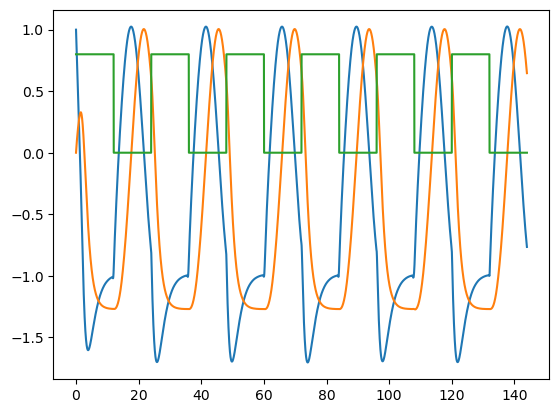

In [51]:
l = .5
tau = 16
max_intensity = .8
intensity = lambda x: LD_step(x) * max_intensity
hours = 144

t, (x, y) = get_simulation_result(l, tau, intensity, hours)

plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, intensity(t))

In [52]:
#SOME MASKING STUFF MARIA IS MESSING AROUND WITH 

import numpy as np
from scipy.integrate import solve_ivp

def light_intensity_with_pulse(t, pulse_start, pulse_duration, pulse_intensity, base_intensity):
    """
    Light intensity function that includes a pulse.
    
    :param t: Current time (hours)
    :param pulse_start: Time at which the pulse starts (hours)
    :param pulse_duration: Duration of the pulse (hours)
    :param pulse_intensity: Intensity of the pulse
    :param base_intensity: Base intensity of the light
    
    :return: Light intensity at time t
    """
    if pulse_start <= t < pulse_start + pulse_duration:
        return pulse_intensity
    else:
        return base_intensity

def cartesian_lights(t, p, l, A, tau, ifunc):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    
    light_intensity = ifunc(t)
    
    dx = l * x * (A - r) - 2 * np.pi * y / tau - light_intensity
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    
    return [dx, dy]

def get_simulation_result(l, tau, pulse_start, pulse_duration, pulse_intensity, base_intensity, hours, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)

    ifunc = lambda t: light_intensity_with_pulse(t, pulse_start, pulse_duration, pulse_intensity, base_intensity)
    
    p0 = [A, 0]
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)

    return t, result.y

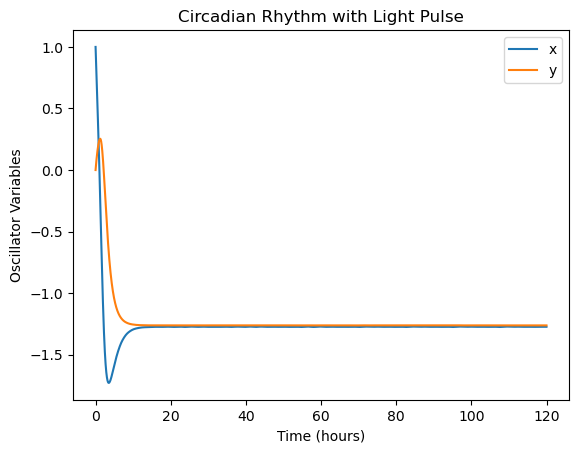

In [53]:
# Parameters for the simulation
l = 0.5  # rate of return from a disturbance
tau = 16  # period of base oscillation (hours)
pulse_start = 60  # start of the pulse (e.g., 60 hours into the simulation)
pulse_duration = 2  # duration of the pulse (2 hours)
pulse_intensity = 1  # intensity of the light pulse
base_intensity = 1  # base light intensity
hours = 144  # total duration of the simulation

# Run the simulation
t, (x, y) = get_simulation_result(l, tau, pulse_start, pulse_duration, pulse_intensity, base_intensity, hours = 120)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.xlabel('Time (hours)')
plt.ylabel('Oscillator Variables')
plt.title('Circadian Rhythm with Light Pulse')
plt.legend()
plt.show()


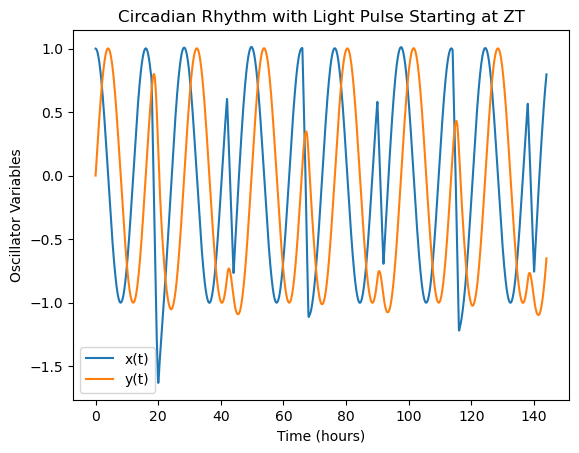

In [54]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def zt_to_hours(zt, light_on_zt, period=24):
    return (zt - light_on_zt) % period

def light_intensity_with_pulse(t, pulse_start_zt, pulse_duration, pulse_intensity, base_intensity, light_on_zt, period=24):
    pulse_start_time = zt_to_hours(pulse_start_zt, light_on_zt, period)
    pulse_end_time = pulse_start_time + pulse_duration
    cycle_time = t % period
    if pulse_start_time <= cycle_time < pulse_end_time:
        return pulse_intensity
    else:
        return base_intensity

def cartesian_lights(t, p, l, A, tau, ifunc):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    light_intensity = ifunc(t)
    dx = l * x * (A - r) - 2 * np.pi * y / tau - light_intensity
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    return [dx, dy]

def get_simulation_result(l, tau, pulse_start_zt, pulse_duration, pulse_intensity, base_intensity, light_on_zt, hours, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    ifunc = lambda t: light_intensity_with_pulse(t, pulse_start_zt, pulse_duration, pulse_intensity, base_intensity, light_on_zt)
    p0 = [A, 0]
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)
    return t, result.y

# simulation
l = 0.5  # rate of return from a disturbance -> how to mess with this
tau = 16  # period of base oscillation (hours)
pulse_start_zt = 18  # start of the pulse at ZT6
pulse_duration = 2  # duration of the pulse (2 hours)
pulse_intensity = 1  # intensity of the light pulse
base_intensity = 0  # base light intensity
light_on_zt = 0  # ZT at which lights turn on
hours = 144  # total duration of the simulation

# Run the simulation
t, (x, y) = get_simulation_result(l, tau, pulse_start_zt, pulse_duration, pulse_intensity, base_intensity, light_on_zt, hours)

# Plot the results
plt.plot(t, x, label='x(t)')
plt.plot(t, y, label='y(t)')
plt.xlabel('Time (hours)')
plt.ylabel('Oscillator Variables')
plt.title('Circadian Rhythm with Light Pulse Starting at ZT')
plt.legend()
plt.show()


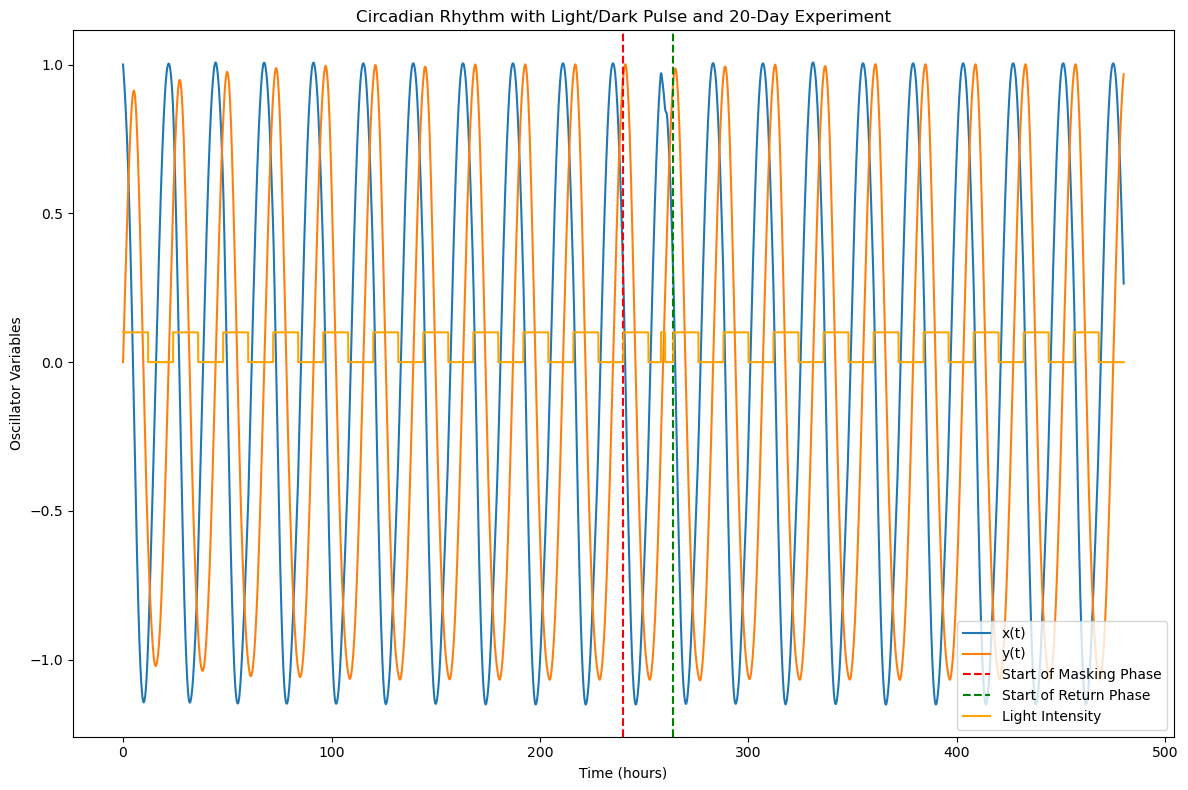

In [88]:
import numpy as np

def light_intensity(t, num_normal_days, num_masking_days, num_return_days, pulse_start_zt, pulse_duration, light_on_zt, period=24):
    day = t // period
    cycle_time = t % period

    pulse_start_time = (pulse_start_zt - light_on_zt) % period
    pulse_end_time = pulse_start_time + pulse_duration
    if day < num_normal_days:
        return 0.1 if light_on_zt <= cycle_time < light_on_zt + period / 2 else 0
    elif day < num_normal_days + num_masking_days:
    
        if pulse_start_time <= cycle_time < pulse_end_time:
            return 0 if light_on_zt <= cycle_time < light_on_zt + period / 2 else 0.1
        else:
            return 0.1 if light_on_zt <= cycle_time < light_on_zt + period / 2 else 0
    else:
        return 0.1 if light_on_zt <= cycle_time < light_on_zt + period / 2 else 0


def cartesian_lights(t, p, l, A, tau, ifunc):
    x, y = p
    r = np.sqrt(x**2 + y**2)
    light_intensity = ifunc(t)
    dx = l * x * (A - r) - 2 * np.pi * y / tau - light_intensity
    dy = l * y * (A - r) + 2 * np.pi * x / tau
    return [dx, dy]

def get_simulation_result(l, tau, num_normal_days, num_masking_days, num_return_days, pulse_start_zt, pulse_duration, light_on_zt, hours, timestep=1/60, A=1):
    tspan = [0, hours]
    t = np.arange(*tspan, timestep)
    ifunc = lambda t: light_intensity(t, num_normal_days, num_masking_days, num_return_days, pulse_start_zt, pulse_duration, light_on_zt)
    p0 = [A, 0]
    result = solve_ivp(cartesian_lights, tspan, p0, args=(l, A, tau, ifunc), t_eval=t)
    return t, result.y

l = 0.5  # rate of return from a disturbance
tau = 24  # period of base oscillation (hours)
pulse_start_zt = 18  # start of the pulse at ZT18
pulse_duration = 2  # duration of the pulse (2 hours)
light_on_zt = 0  # ZT at which lights turn on 

num_normal_days = 10
num_masking_days = 1  # Day 11 is the masking day
num_return_days = 9
hours = (num_normal_days + num_masking_days + num_return_days) * 24

t, (x, y) = get_simulation_result(l, tau, num_normal_days, num_masking_days, num_return_days, pulse_start_zt, pulse_duration, light_on_zt, hours)

light_intensity_values = np.array([light_intensity(ti, num_normal_days, num_masking_days, num_return_days, pulse_start_zt, pulse_duration, light_on_zt) for ti in t])

plt.figure(figsize=(12, 8))

plt.plot(t, x, label='x(t)')
plt.plot(t, y, label='y(t)')
plt.axvline(x=num_normal_days*24, color='r', linestyle='--', label='Start of Masking Phase')
plt.axvline(x=(num_normal_days + num_masking_days) * 24, color='g', linestyle='--', label='Start of Return Phase')
plt.xlabel('Time (hours)')
plt.ylabel('Oscillator Variables')
plt.title('Circadian Rhythm with Light/Dark Pulse and 20-Day Experiment')
plt.plot(t, light_intensity_values, label='Light Intensity', color='orange')
plt.legend()

plt.tight_layout()
plt.show()
